# Predikce vývoje časových řad

## Načtení dat
Použijeme data z World Bank.

In [3]:
import pandas as pd
import world_bank_data as wb
import datetime

dataset_props = {
    'SP.DYN.TFRT.IN': {
        'id': 'tfr',
        'name': 'Total fertility rate',
        'description': 'Počet dětí, které by žena mohla mít, kdyby po celý její život platily hodnoty plodnosti podle věku pro daný rok.',
        'unit': 'počet dětí'
    },
    'EN.ATM.CO2E.KT': {
        'id': 'co2_emissions',
        'name': 'Emise CO2',
        'description': 'Emise CO2 vzniklé spalování fosilních paliv a výrobou cementu.',
        'unit': 'kt'
    },
    'NY.GDP.PCAP.PP.CD': {
        'id': 'gdp',
        'name': 'HDP per capita',
        'description': 'HDP per capita v mezinárodních dolarech podle parity kupní síly',
        'unit': 'mezinárodní dolary'
    },
    'SL.TLF.CACT.FE.ZS': {
        'id': 'lfp_female',
        'name': 'Participace žen 15+ v pracovním procesu',
        'description': 'Podíl ekonomicky aktivních žen ve věku 15 a více let (odhad ILOSTAT)',
        'unit': '%'
    },
    'SH.STA.SUIC.P5': {
        'id': 'suicide_mortality_rate',
        'name': 'Sebevražednost',
        'description': 'Hrubý počet sebevražd na 100000 obyvatel (WHO)',
        'unit': 'počet sebevražd'
    }
}

regions = [
    'WLD', # World
    'EUU', # European Union
    'CZE',
    'DEU',
    'GRC',
    'ITA',
    'POL',
    'GBR'
]

datasets = {}
for dataset_id in dataset_props:
    # Collect data since 1980 until now
    year = datetime.date.today().strftime("%Y")
    series = wb.get_series(dataset_id, date='1980:%s' % year, id_or_value='id', simplify_index=True)

    # Process dataset for each selected region
    per_region = {}

    for region in regions:
        data = series[region]

        # Strip NaNs
        index = data.index
        start = 0
        while start <= len(index) - 1:
            if not pd.isnull(data[index[start]]):
                break
            start = start + 1
        end = len(index) - 1
        while end >= 0:
            if not pd.isnull(data[index[end]]):
                break
            end = end - 1
        data = data.iloc[start:(end + 1)] # Last index is exclusive

        # Compute intermediary missing values using interpolation
        data = data.interpolate()

        if data.size < 3:
            print('Skipping %s for %s' % (dataset_id, region))

        per_region[region] = {
            'data': data
        }

    datasets[dataset_id] = per_region

tfr = datasets.pop('SP.DYN.TFRT.IN')

print(tfr['WLD']['data'].size)

41


## Autoregresní model (AR)
Predikujeme TFR pomocí jeho vlastních předchozích hodnot.
Máme k dispozici 41 hodnot, které rozdělíme v poměru 3:1 na trénovací a testovací dataset.
Vyzkoušíme také použít různý počet předchozích hodnot.

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


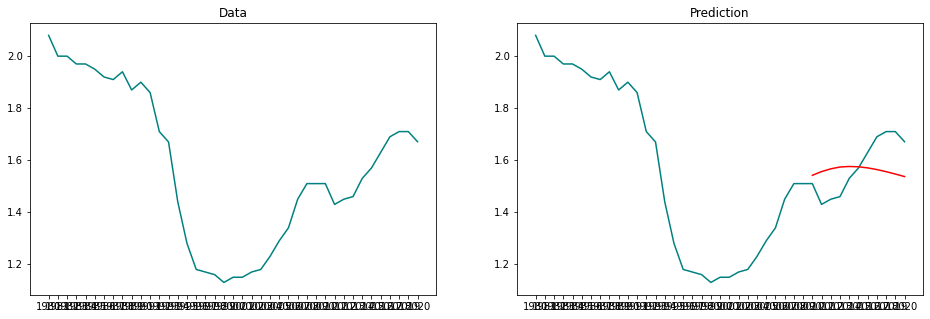

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


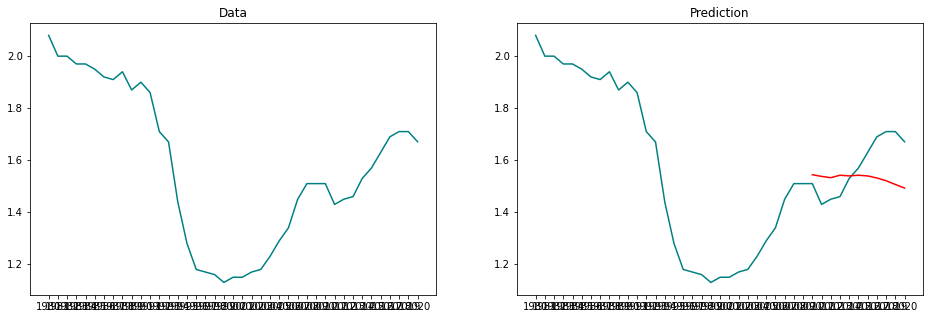

/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/gemsee/.local/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


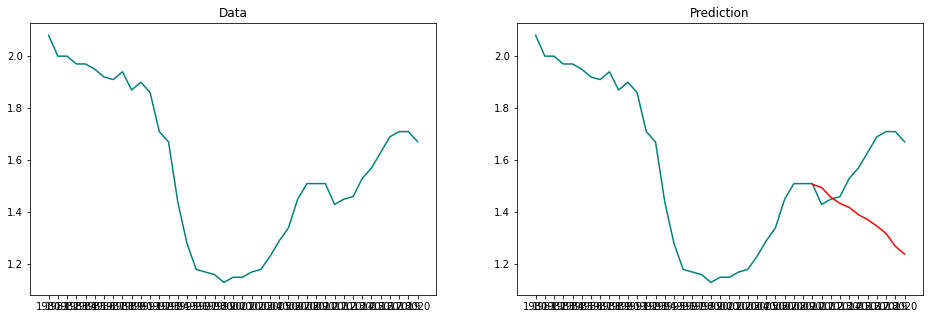

In [75]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

data = tfr['CZE']['data']

def ar(data, train_count, lags):
    train, test = data[:train_count],data[train_count:]

    # Unset frequency, as the data is most probably not periodic
    train.index = pd.DatetimeIndex(train.index.values)

    model = AutoReg(train, lags=lags, trend='c')
    model_fit = model.fit()

    pred = model_fit.predict(len(train), len(test) + len(train) - 1, dynamic=False)

    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(5)
    plt.subplot(1, 2, 1)
    plt.title('Data')
    plt.plot(data, color='teal')
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.plot(data, color='teal')
    plt.plot(test.index, pred.values, color='red')
    plt.show()

ar(data, 30, 4)
ar(data, 30, 8)
ar(data, 30, 13)

## Parciální korelace
Je patrné, že autoregresní model je citlivý na počet lagů, které použijeme.
Najdeme proto jejich optimální počet pomocí grafu parciálních autokorelací podle lagu.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

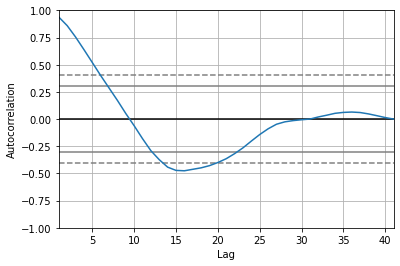

In [52]:
pd.plotting.autocorrelation_plot(data)

Prvních pět hodnot významně autokoreluje, vztah je také ještě silný mezi třináctou a dvacátou hodnotou.
Relativně velký počet významně korelujících lagů a silná autokorelace prvních pár lagů naznačuje, že časová řada podléhá změnám trendu a je nestacionární.
Toto zjištění souhlasí s postupem v noteboocích pracujících s korelacemi mezi datovými sadami, kde sice ne všechny vývoje TFR byly označeny za nestacionární, ale výsledky po diferenciaci se jevily věrohodnější.
Autoregresní model proto nelze použít.

In [76]:
# ar(data, 30, 5)

# def ar_all(data, lags):
#     model = AutoReg(data, lags=lags, trend='c', seasonal=False)
#     model_fit = model.fit()

#     pred = model_fit.predict(len(data), len(data) + lags, dynamic=False)

#     fig = plt.figure()
#     fig.set_figwidth(16)
#     fig.set_figheight(5)
#     plt.title('Prediction')
#     plt.plot(range(len(data)), data, color='teal')
#     plt.plot(range(len(data), len(data) + len(pred.values)), pred.values, color='red')
#     plt.show()
# ar_all(data, 19)